# Transportation Access Classifier

Welcome to this project where we build an efficient **image classifier** using **TensorFlow** and the **MobileNetV2** architecture.

MobileNetV2 is a lightweight deep neural network designed for mobile and embedded vision applications. It balances **accuracy** and **speed**, making it a great choice for image classification tasks.

### 🛠️ Project Overview
- **Model:** MobileNetV2 (pre-trained on ImageNet)
- **Task:** Classify images into multiple categories
- **Data:** Custom dataset organized into train/validation folders( the links to the dataset is mentioned below)
- **Frameworks:** TensorFlow, Keras
- **Hardware:** CPU (no GPU)

---

### 📋 Steps Covered
1. Data Preparation and Augmentation
2. Model Building and Customization
3. Model Training and Saving
4. Model Evaluation
5. Visualization of Training History

---

### 🎯 Objectives
- Leverage transfer learning to speed up training
- Achieve high classification accuracy
- Save the trained model for future use
- Visualize performance with loss and accuracy graphs

---

The links to the datasets: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset , https://universe.roboflow.com/kicksquad/scooter-only, https://www.kaggle.com/datasets/mmohaiminulislam/vehicles-image-dataset

The link to the research paper of the model we used: https://arxiv.org/abs/1801.04381



## First Step 
### Importing the important libraries and Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='PIL.Image')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-04-28 22:43:43.924601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 22:43:43.930964: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 22:43:43.978896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 22:43:44.019477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745865824.058463    5625 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745865824.06

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001


In [3]:

""" 
Initially We create ImageDataGenerator objects for training, validation, and test datasets.
The training data generator includes data augmentation techniques such as rotation, width and height shifts, and horizontal flips to improve the model's robustness.
The validation and test data generators only rescale the pixel values to the range [0, 1].
The `flow_from_directory` method is used to load images from the specified directories, with the target size set to (224, 224) pixels and a batch size of 32.
The `class_mode` is set to 'categorical' for multi-class classification, and the color mode is set to 'rgb'.
The `shuffle` parameter is set to True for the training data to ensure that the model sees a different order of images in each epoch, while it is set to False for validation and test data to maintain the order of images.
"""
#70/15/15
train_dir = 'dataset/train'
validation_dir = 'dataset/val'
test_dir = 'dataset/test'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',  
    classes=None,  
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb', 
    classes=None,  
    shuffle=False
)



test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)



Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [4]:
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 3
Class indices: {'car': 0, 'denied': 1, 'scooter': 2}


## Second Step 
### Model Building and  Customization

In [5]:
"""
In this section, we define the MobileNetV2 model architecture.
We use the pre-trained MobileNetV2 model with ImageNet weights, excluding the top classification layer.
We set the input shape to (224, 224, 3) to match the input size of our images.
We freeze all layers except the last 4 layers of the base model to retain the learned features from ImageNet while allowing the last few layers to be trainable for our specific dataset.
We add a global average pooling layer to reduce the spatial dimensions of the feature maps, followed by a fully connected layer with 1024 units and ReLU activation.
We then add a final output layer with the number of classes and softmax activation for multi-class classification.
The model is compiled with the Adam optimizer, categorical crossentropy loss function, and accuracy metric.
"""

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-4]:  
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions, name='CustomMobileNetV2')

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary() # This gives the summary of the model architecture  including the one we added recently and the base model along with the number of parameters
print("Number of Layers:",len(model.layers))

2025-04-28 22:43:46.468129: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "CustomMobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,572,803 (13.63 MB)

 Trainable params: 1,727,619 (6.59 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

Number of Layers: 157


## Third Step 
### Model Training and Saving

In [6]:
history = model.fit(
    train_generator,
     epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

model.save('mobilenet_transport_access_classifier.keras')
print("Model saved as mobilenet_transport_access_classifier.keras")

/home/roba/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 643ms/step - accuracy: 0.7853 - loss: 0.5148 - val_accuracy: 0.8911 - val_loss: 0.2706
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 633ms/step - accuracy: 0.9487 - loss: 0.1377 - val_accuracy: 0.9133 - val_loss: 0.2413
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 665ms/step - accuracy: 0.9648 - loss: 0.1052 - val_accuracy: 0.9089 - val_loss: 0.2845
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 617ms/step - accuracy: 0.9580 - loss: 0.1244 - val_accuracy: 0.9244 - val_loss: 0.1854
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.9784 - loss: 0.0628 - val_accuracy: 0.9422 - val_loss: 0.1889
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 622ms/step - accuracy: 0.9779 - loss: 0.0634 - val_accuracy: 0.9467 - val_loss: 0.1697
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 624ms/step - accuracy: 0.9733 - loss: 0.0703 - val_accuracy: 0.9400 - val_loss: 0.1991
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 625ms/step - accuracy: 0.9845 - loss: 0.0489 - val_accu

## Fourth Step
### Model Evaluation on Test Data

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.9633 - loss: 0.0648
Test accuracy: 0.9622222185134888
Test loss: 0.07853290438652039


## Fifth Step
### Visualizing the Training History

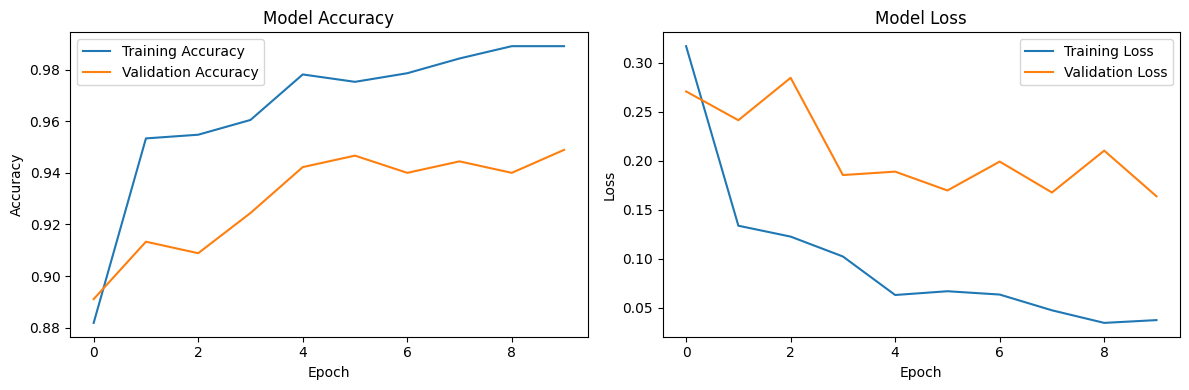

Training history plot saved as 'training_history.png'


In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()
plt.close()
print("Training history plot saved as 'training_history.png'")
